## 0.Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import glob
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import math
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from keras import optimizers

2024-06-25 22:45:31.183417: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-25 22:45:31.236239: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-25 22:45:31.489740: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 22:45:31.489800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 22:45:31.537755: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## 1. Load Dataset

In [2]:
dir = 'Nrefined_dataset'
listdir = os.listdir(dir)

print(listdir)
print("The number of dataset :", len(listdir))

['NB34.csv', 'NB18.csv', 'NB46.csv', 'NB05.csv', 'NB33.csv', 'NB48.csv', 'NB07.csv', 'NB47.csv']
The number of dataset : 8


In [3]:
num = ['NB05', 'NB07', 'NB18', 'NB33', 'NB34', 'NB46', 'NB47', 'NB48']
for i in range(len(listdir)):
    vector = np.zeros((1,3))
    path = os.path.join(os.getcwd(), 'Nrefined_dataset/', num[i] + '.csv')
    csv = pd.read_csv(path)
    df = pd.DataFrame(csv)
    
    vec = df[['cycle', 'capacity', 'SOH','gasSensor']]
    
    globals()['data_{}'.format(num[i])] = vec

In [4]:
data = pd.read_csv('Nrefined_dataset/NB05.csv')
df = pd.DataFrame(data)
df

,terminal_voltage,terminal_current,temperature,charge_current,charge_voltage,time,capacity,cycle,SOH,gasSensor
0,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000,1.856487,1,0.928244,0.107634
1,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781,1.856487,1,0.928244,0.107634
2,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703,1.856487,1,0.928244,0.107634
3,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781,1.856487,1,0.928244,0.107634
4,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922,1.856487,1,0.928244,0.107634
...,...,...,...,...,...,...,...,...,...,...
50280,3.579262,-0.001569,34.864823,0.0006,0.000,2781.312,1.325079,168,0.662540,0.506191
50281,3.581964,-0.003067,34.814770,0.0006,0.000,2791.062,1.325079,168,0.662540,0.506191
50282,3.584484,-0.003079,34.676258,0.0006,0.000,2800.828,1.325079,168,0.662540,0.506191
50283,3.587336,0.001219,34.565580,0.0006,0.000,2810.640,1.325079,168,0.662540,0.506191


In [5]:
data_NB05  ## result

,cycle,capacity,SOH,gasSensor
0,1,1.856487,0.928244,0.107634
1,1,1.856487,0.928244,0.107634
2,1,1.856487,0.928244,0.107634
3,1,1.856487,0.928244,0.107634
4,1,1.856487,0.928244,0.107634
...,...,...,...,...
50280,168,1.325079,0.662540,0.506191
50281,168,1.325079,0.662540,0.506191
50282,168,1.325079,0.662540,0.506191
50283,168,1.325079,0.662540,0.506191


In [6]:
for i in range(len(listdir)):
    print("Shape of data :", np.shape(globals()['data_{}'.format(num[i])]))

Shape of data : (50285, 4)
Shape of data : (50285, 4)
Shape of data : (34866, 4)
Shape of data : (42200, 4)
Shape of data : (45909, 4)
Shape of data : (23478, 4)
Shape of data : (23478, 4)
Shape of data : (23478, 4)


In [7]:
print(listdir)
dataset = data_NB48["SOH"]
cycle = data_NB48['cycle']
gas = data_NB48['gasSensor']

dataset = np.array(dataset)
dataset = dataset.reshape((len(dataset),1))
dataset.shape

['NB34.csv', 'NB18.csv', 'NB46.csv', 'NB05.csv', 'NB33.csv', 'NB48.csv', 'NB07.csv', 'NB47.csv']


(23478, 1)

## 2. Split train and test dataset

In [8]:
train_size = int(len(dataset) * 0.5)
# train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

11739 11739


In [9]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [10]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

11738
11738


In [11]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(trainX.shape)
print(testX.shape)

(11738, 1, 1)
(11738, 1, 1)


## 3. Training with LSTM

In [12]:
model = Sequential()
model.add(LSTM(40, input_shape=(trainX.shape[1], trainX.shape[2])))

model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')

In [13]:
history = model.fit(trainX, trainY, epochs=1000, batch_size=30, validation_data=(testX, testY), verbose=1, shuffle = False)

# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_train)

Epoch 1/1000
392/392 [==============================] - 3s 4ms/step - loss: 0.1045 - val_loss: 0.0085
Epoch 2/1000
392/392 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0084
Epoch 3/1000
392/392 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0083
Epoch 4/1000
392/392 [==============================] - 1s 3ms/step - loss: 0.0052 - val_loss: 0.0083
Epoch 5/1000
392/392 [==============================] - 1s 3ms/step - loss: 0.0054 - val_loss: 0.0082
Epoch 6/1000
392/392 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0082
Epoch 7/1000
392/392 [==============================] - 1s 3ms/step - loss: 0.0049 - val_loss: 0.0082
Epoch 8/1000
392/392 [==============================] - 1s 3ms/step - loss: 0.0055 - val_loss: 0.0082
Epoch 9/1000
392/392 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0081
Epoch 10/1000
392/392 [==============================] - 1s 2ms/step - loss: 0.004

In [14]:
# save model architecture
model_json = model.to_json()
open('50%/model/NB48_model.json', 'w').write(model_json)

# save model's learned weights
model.save_weights('50%/model/NB48_weights.h5', overwrite=True)

In [15]:
# Load trained model
from keras.models import model_from_json 

json_file = open("50%/model/NB48_model.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)
 
# model weight load 
loaded_model.load_weights("50%/model/NB48_weights.h5")
print("Loaded model from disk")

Loaded model from disk


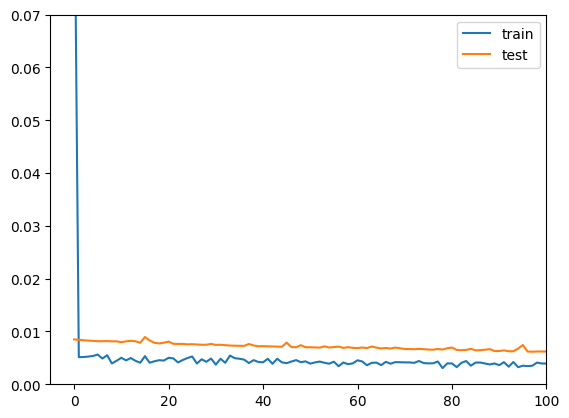

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.axis([-5, 100, 0, 0.07])
plt.legend() 
plt.show()

367/367 [==============================] - 0s 935us/step


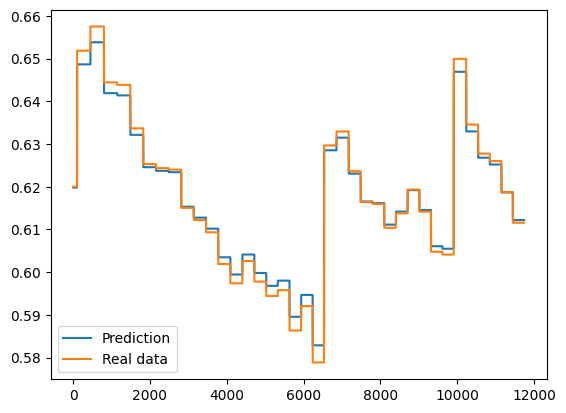

In [17]:
yhat = model.predict(testX)
tyhat = model.predict(trainX)
plt.plot(yhat, label='Prediction')
plt.plot(testY, label='Real data')
plt.legend()
plt.show()

In [18]:
print("Shape of train data :", trainX.shape)
print("Shape of prediction :", yhat.shape)
print("Shape of real data :", testY.shape)

Shape of train data : (11738, 1, 1)
Shape of prediction : (11738, 1)
Shape of real data : (11738,)


In [19]:
rmse = math.sqrt(mean_squared_error(testY, yhat))
mae = mean_absolute_error(testY, yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

Test RMSE: 0.002
Test MAE: 0.001


## 4. Visualization

In [20]:
print("Shape of cycle :", np.shape(cycle))

cycle1 = cycle[0:train_size-1]
cycle2 = cycle[train_size+1:len(dataset)]

# cycle1 = cycle[0:train_size]
# cycle2 = cycle[train_size:len(dataset)]

print(np.shape(cycle1), np.shape(cycle2))

Shape of cycle : (23478,)
(11738,) (11738,)


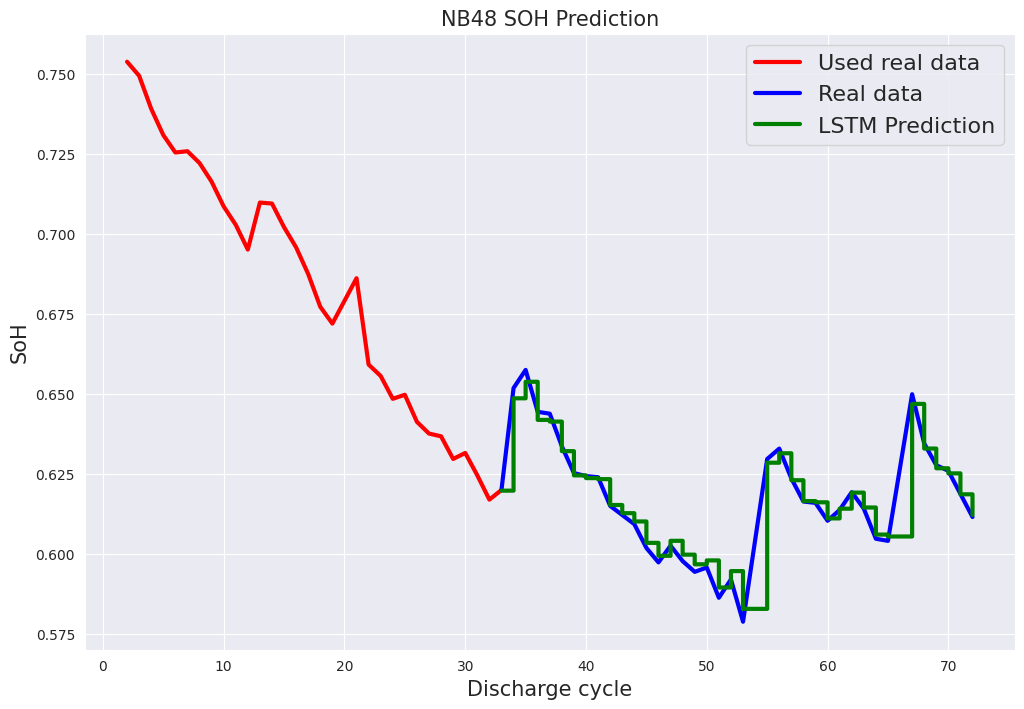

In [21]:
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))

plt.plot(cycle1, trainX[:,0],label='Used real data', linewidth = 3, color='r')
plt.plot(cycle2, testY,label='Real data', linewidth = 3, color='b')
# plt.plot(cycle2, yhat[:,0],label='LSTM Prediction', linewidth = 3, color='g')
plt.plot(cycle2, yhat[:,0],label='LSTM Prediction', linewidth = 3, color='g')
plt.legend(prop={'size': 16})

plt.ylabel('SoH', fontsize = 15)
plt.xlabel('Discharge cycle', fontsize = 15)
plt.title(str(num[7]) + " SOH Prediction", fontsize = 15)
plt.savefig('50%/fig/' + str(num[7]) + '_LSTM.jpg')
plt.show()